# Remote sensing building extraction to 3D model using Paddle and Grasshopper
The domestic deep learning platform PaddlePaddle plus the visual programming language Grasshopper (based on the Rhino platform), how to quickly generate building models from remote sensing images? Wait and see~ ~

*【It can be regarded of the previous project[Rhino(Grasshopper)+PaddleX快速建模](https://aistudio.baidu.com/aistudio/projectdetail/1311631)as a detailed sorting , using a new data set and post-processing method (simplified boundary), canceling the building height prediction (inaccurate) and changing it to random Height (big guy can also be changed to calculate the height according to the shadow of the building)] 】*

# One, model training 
Model training uses PaddleSeg suite, PaddleSeg is an end-to-end image segmentation development suite developed based on flying paddle PaddlePaddle, covering a large number of high-quality segmentation models in different directions such as high-precision and lightweight. Through the modular design, two application methods are provided, such as configuration drive and API call, to help developers more conveniently complete the entire image segmentation application from training to deployment 
- model：Unet++
- dataset：Aerial imagery dataset

## 1. Install dependencies/decompress data sets
- You need to pip paddleseg before each run 
- The data set does not need to be decompressed repeatedly. The original aerial imagery data of the Aerial imagery dataset comes from the New Zealand Land Information Service website. This aerial imagery (including 187,000 buildings) is down-sampled to a ground resolution of 0.3m and cropped into 8189 tiles of 512×512 pixels. The original training set, validation set and test set are merged here (the original data comes from the Photogrammetry and Computer Vision Group (GPCV) of Wuhan University-Ji Shunping. Introduction to Intelligent Photogrammetry [M], Science Press, 2018. 4 moon. 

In [ ]:
! pip install paddleseg # Already installed in docker (requirements.txt)
! unzip -q /home/aistudio/data/data69911/BuildData.zip -d DataSet

## 2. Generate data list 
Generate training set and test set according to 9:1, after the data list is generated, there is no need to run this module repeatedly 

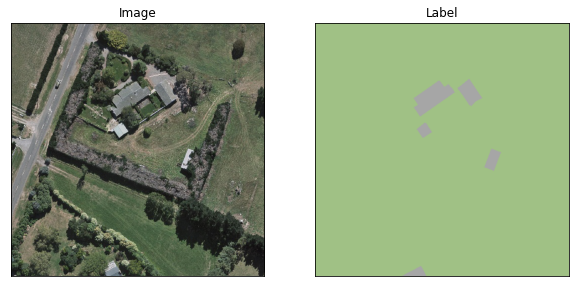

In [11]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def create_list(data_path):
    image_path = os.path.join(data_path, 'image')
    label_path = os.path.join(data_path, 'label')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # Scramble data
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('image', data_name)
                lab = os.path.join('label', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90% as the training set
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('Data list generation completed')

data_path = 'DataSet'
# create_list(data_path)  # Generate data list

# View a set of data
vis_img = Image.open('DataSet/image/0045.jpg')
vis_lab = Image.open('DataSet/label/0045.png')
plt.figure(figsize=(10, 20))
plt.subplot(121);plt.imshow(vis_img);plt.xticks([]);plt.yticks([]);plt.title('Image')
plt.subplot(122);plt.imshow(vis_lab);plt.xticks([]);plt.yticks([]);plt.title('Label')
plt.show()

## 3. Train the network 
Using the Unet++ network provided by PaddleSeg, the author of this network[知乎](https://zhuanlan.zhihu.com/p/44958351)the design concept of Unet++ very clearly. Compared with the original Unet network, in order to avoid the fusion of the semantically dissimilar features of pure jump connections in UNet, UNet++ further strengthens these connections by introducing nested and dense jump connections, with the purpose of reducing encoders and decoding Semantic gap 
![](https://ai-studio-static-online.cdn.bcebos.com/f88be55d83194551acfe8c324f0b5c8ba98ed0b9fc94437b93c2cfe4f54babbd)

In [12]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.models.losses import BCELoss
from paddleseg.core import train

def train_model(base_lr=0.00001, iters=10000, batch_size=8, model_path=None):
    # Network definition
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # Build the training set
    train_transforms = [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(),
        T.RandomScaleAspect(),
        T.RandomDistort(),
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    train_dataset = Dataset(
        transforms=train_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='train',
        train_path='DataSet/train_list.txt',
        separator=' ',
    )
    # Build validation set
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    # parameter settings
    lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=2000, last_epoch=0.5)
    optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters())
    losses = {}
    losses['types'] = [BCELoss()]
    losses['coef'] = [1]
    # train
    train(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        optimizer=optimizer,
        save_dir='output',
        iters=iters,
        batch_size=batch_size,
        save_interval=int(iters/5),
        log_iters=10,
        num_workers=0,
        losses=losses,
        use_vdl=True)

# train_model(iters=1000, model_path='output/model_kp0.9085/model.pdparams')

## 4. Evaluation
You can see that the evaluation result of the best model is not bad 
```
[EVAL] #Images=910 mIoU=0.9143 Acc=0.9773 Kappa=0.9085 
[EVAL] Class IoU: [0.8549 0.9738]
[EVAL] Class Acc: [0.935  0.9843]
```

In [ ]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.core import evaluate

def eval_model(model_path=None):
    # Network definition
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # Build validation set
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    evaluate(
        model,
        val_dataset
    )

eval_model(model_path='output/model_kp0.9085/model.pdparams')

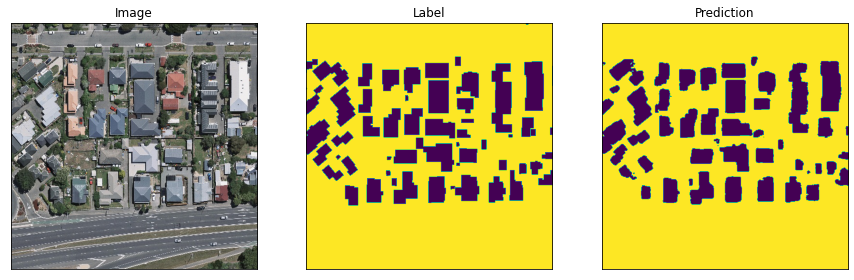

In [16]:
import numpy as np
import paddle
from PIL import Image
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.core import infer
import matplotlib.pyplot as plt

def nn_infer(img_path, lab_path, model_path='output/model_kp0.9085/model.pdparams', show=True):
    # Network definition
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # forecast result
    transforms = T.Compose([
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ])
    img, lab = transforms(img_path, lab_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    if show:
        plt.figure(figsize=(15, 45))
        plt.subplot(131);plt.imshow(Image.open(img_path));plt.xticks([]);plt.yticks([]);plt.title('Image')
        plt.subplot(132);plt.imshow(lab.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Label')
        plt.subplot(133);plt.imshow(pred.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Prediction')
        plt.show()
    return pred.astype('uint8')

name = '5255'
img_path = 'DataSet/image//' + name + '.jpg'
lab_path = 'DataSet/label//' + name + '.png'
_ = nn_infer(img_path, lab_path)

## 5. The network's outcome prediction 
Take the 5255 group of images as an example to view the predicted results 

## 6. Opencv post-processing (*adaptive modeling) 
It is not enough to just get the segmentation results here. In order to model fewer faces and simple shapes, the following operations can or need to be performed: 
- Perform opening operations and remove small connections
- Calculate the connected area, delete the connected area less than a certain threshold 
- Fit the boundary to simplify the shape 

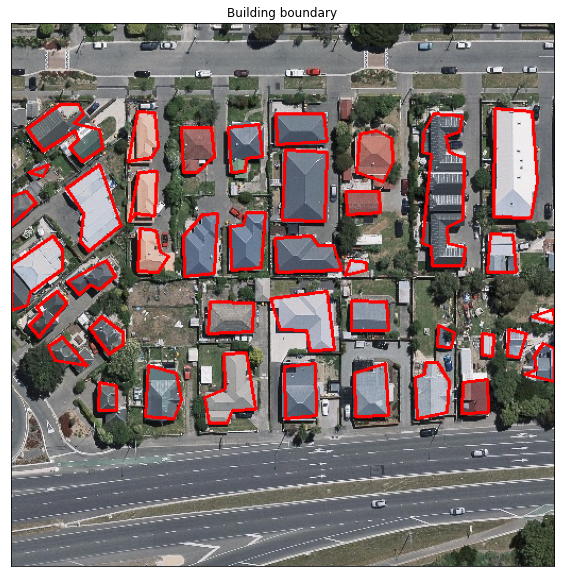

In [6]:
import cv2

def build_extracter(
    img_path,
    model_path='output/model_kp0.9085/model.pdparams',
    threshold_area=200,  # Remove the small threshold of the Unicom area
    threshold_area_simplify=5,  # Boundary simplification factor
    open_comput=False,  # Whether to open
    open_kernel_size=9,  # Core size for open operation
    show=True
    ):
    cv_img = nn_infer(img_path, lab_path, model_path, show=False)
    cv_img = np.uint8(~(cv_img.astype(bool)))
    # 开运算
    if open_comput:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_kernel_size, open_kernel_size))
        cv_img = cv2.morphologyEx(cv_img, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bods = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > threshold_area:  # Screen the small connecting area
            out = cv2.approxPolyDP(contour, threshold_area_simplify, True)  # 简化形状
            bods.append(out)
    if show:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        cimg = cv2.drawContours(img, bods, -1, (255, 0, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.title('Building boundary')
        plt.imshow(cimg);plt.xticks([]);plt.yticks([])
        plt.show()
    return bods

conts = build_extracter(img_path)

## 7. Export prediction model 
Use paddle.jit.save to save the model as a predictive model 

In [7]:
import paddle
from paddle.static import InputSpec
from paddleseg.models import UNetPlusPlus

def output_inf_model(params_path, save_path):
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    para_state_dict = paddle.load(params_path)
    model.set_dict(para_state_dict)
    paddle.jit.save(model, save_path, [InputSpec([None, 3, 512, 512], 'float32')])

params_path = 'output/model_kp0.9085/model.pdparams'
save_path = "output_inf/UnetPP"
# output_inf_model(params_path, save_path)

## 8. Test load prediction model 
Use paddle.jit.load to load the model in to ensure that the exported prediction model can be used normally 

/usr/local/lib/python3.8/site-packages/paddle/fluid/backward.py:1697: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  return list(x) if isinstance(x, collections.Sequence) else [x]


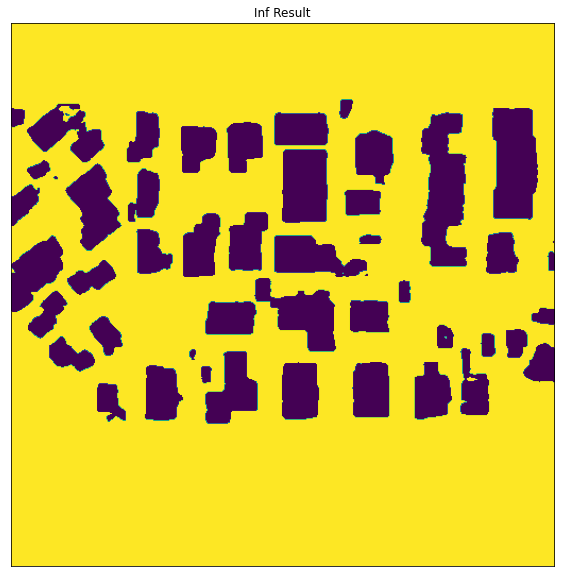

In [8]:
import paddle
import paddleseg.transforms as T
import numpy as np
import matplotlib.pyplot as plt

save_path = "output_inf/UnetPP"
img_path = 'DataSet/image/5255.jpg'
inf_model = paddle.jit.load(save_path)
inf_model.eval()
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])
img, _ = transforms(img_path)
img = paddle.to_tensor(img[np.newaxis, :])
pre = inf_model(img)
pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(pred.astype('uint8'));plt.title('Inf Result');plt.xticks([]);plt.yticks([])
plt.show()

# Two, Grasshopper model deployment 
The above operations in AI Studio have been completed, and the following operations cannot be run, and will be described using Markdown. Need to operate locally on the computer with Rhino (with Grasshopper) 

## 1. Export the model to local 
Select in the left folder`output_inf`，Click the download icon on the right to download the prediction model to a local task folder. Unzip and copy the files inside to the outer layer (AI Studio downloads will have the path home\aistudio\ by default) 

## 2. Create a python environment 
Use conda to create a new virtual environment, you need pip on numpy, paddlepaddle, paddleseg, opencv, (whatever) named pdseg 
```
conda create -n pdseg python=3.7
pip install paddlepaddle/paddleseg/opencv-python……
```

# 3. Configure the grasshopper environment 
Grasshopper (GH for short) is a visual programming language that runs on the Rhino platform. It is one of the mainstream software in the direction of digital design, and it also overlaps with interactive design. Compared with traditional design methods, GH has two biggest features: one is that the computer can automatically generate results according to the proposed algorithm by inputting instructions. The algorithm results are not limited to models, video streaming media, and visualization solutions. The second is that by writing algorithm programs, mechanical repetitive operations and a large number of logical evolution processes can be replaced by computer cyclic operations, and program adjustments can also directly obtain modified results through parameter modifications. These methods can effectively improve the work of designers. efficient 
- You need to download ghcpython. Grasshopper comes with python as ipython based on .net. To do deep learning predictions, you need to use native python, which can be satisfied by ghcpython 
- Drag in the ghcpython battery, select Python->Choose Interpreter in the menu bar, and set the python to be used in the pdseg environment in the virtual environment (the environment configured in the second step). 

## 4. Write the code and connect the battery 
As shown in the figure, the logic is relatively clear, namely 
1. First read the image and move it to the appropriate position 
2. Use predictive models for image segmentation to extract buildings 
3. Use opencv for post-processing, and change the data into a list of coordinate points such as [xy], which is convenient for Grasshopper to convert into its own point and line data 
4. Use the built-in python to convert into a data type that can be modeled 
5. Connect the border and pull out a certain height 
6. Capped 

* ps：The display here uses the TopMostViewport for Rhino floating window top plug-in 
* `.gh`The file has been placed in the folder 

![](https://ai-studio-static-online.cdn.bcebos.com/dbd00e2ecae84d25a22255da0f23ad51d121311d45d74ac4afc1bafe5162f1aa)


## 5. Animation effect 
At most 1M is really tired, showing the effect of changing the minimum/maximum storeys, storey heights and boundary simplification parameters of the building~ 

![](https://ai-studio-static-online.cdn.bcebos.com/f4eb1dbc7bc5417f90f793c48c53495fe132753797274322b478351b153a9926)

# about 

| Name | Chen Yizhou |
| -------- | -------- |
| School/Professional | Surveying and Mapping Science and Technology, Chongqing Jiaotong University |
| Home page | https://aistudio.baidu.com/aistudio/personalcenter/thirdview/1945 |

I hope to communicate more with everyone, especially the remote sensing students. 